# Content-based Recommendation System in Python
### Using Natural Language Processing (NLP) on wine reviews to recommend the next purchase

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import math
import re
import nltk
import time
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from rake_nltk import Rake

from collections import defaultdict
import progressbar
from IPython.display import HTML

%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
sns.set()
pd.options.display.max_colwidth = 100

In [2]:
# Loading the data
df = pd.read_csv('data/winemag-data-130k-v2.csv')
del df['Unnamed: 0']
# Show df to get an idea of the data
df.head(10)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressi...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled o...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and rind dominate. Some green pineapple pokes through...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opu...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling (Lake Michigan Shore),Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this comes across as rather rough and tannic, with rus...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child Block Pinot Noir (Willamette Valley),Pinot Noir,Sweet Cheeks
5,Spain,"Blackberry and raspberry aromas show a typical Navarran whiff of green herbs and, in this case, ...",Ars In Vitro,87,15.0,Northern Spain,Navarra,NaN,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (Navarra),Tempranillo-Merlot,Tandem
6,Italy,"Here's a bright, informal red that opens with aromas of candied berry, white pepper and savory h...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,NaN,Kerin O’Keefe,@kerinokeefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo
7,France,This dry and restrained wine offers spice in profusion. Balanced with acidity and a firm texture...,NaN,87,24.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Trimbach 2012 Gewurztraminer (Alsace),Gewürztraminer,Trimbach
8,Germany,"Savory dried thyme notes accent sunnier flavors of preserved peach in this brisk, off-dry wine. ...",Shine,87,12.0,Rheinhessen,NaN,NaN,Anna Lee C. Iijima,NaN,Heinz Eifel 2013 Shine Gewürztraminer (Rheinhessen),Gewürztraminer,Heinz Eifel
9,France,This has great depth of flavor with its fresh apple and pear fruits and touch of spice. It's off...,Les Natures,87,27.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Jean-Baptiste Adam 2012 Les Natures Pinot Gris (Alsace),Pinot Gris,Jean-Baptiste Adam


## Data Analysis and definition of the blog's goal

### How many different Taster are in the dataset?

In [3]:
df.taster_name.nunique()

19

There are 19 different Taster in the dataset

### Have those Taster a different profile?

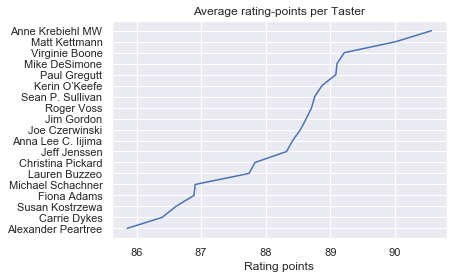

In [4]:
taster = df.groupby('taster_name').points.mean().sort_values()
y = taster.index.to_list()
x = taster.to_list()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, y)

ax.set_title('Average rating-points per Taster')
ax.set_xlabel('Rating points')

plt.show()
#plt.savefig('Average_Rating_Taster')

### How are the reviews distributed across the varieties of the wines?

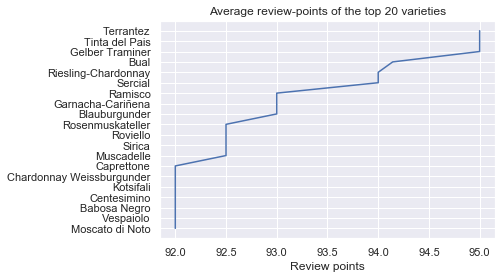

In [5]:
var = df.groupby('variety').points.mean().sort_values()[-20:]
y = var.index.to_list()
x = var.to_list()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, y)

ax.set_title('Average review-points of the top 20 varieties')
ax.set_xlabel('Review points')

plt.show()
#plt.savefig('Average_rating_top20')

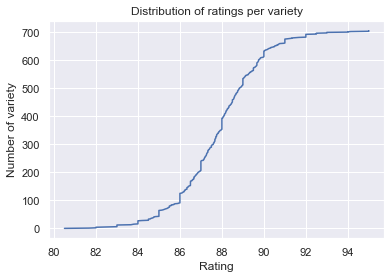

In [6]:
var = df.groupby('variety').points.mean().sort_values()
#y = var.index.to_list()
x = var.to_list()
y = range(0,len(var))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x,y)

ax.set_title('Distribution of ratings per variety')
ax.set_ylabel('Number of variety')
ax.set_xlabel('Rating')

plt.show()
#plt.savefig('Average_rating_bottom20')

### Understanding the written description

In [7]:
# Taking a look at the describtions
for i in range(1,5):
    print(i)
    print(df['description'].loc[i])

1
This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's  already drinkable, although it will certainly be better from 2016.
2
Tart and snappy, the flavors of lime flesh and rind dominate. Some green pineapple pokes through, with crisp acidity underscoring the flavors. The wine was all stainless-steel fermented.
3
Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish.
4
Much like the regular bottling from 2012, this comes across as rather rough and tannic, with rustic, earthy, herbal characteristics. Nonetheless, if you think of it as a pleasantly unfussy country wine, it's a good companion to a hearty winter stew.


In [8]:
# setting stopwords for now and later use
stop_words = set(stopwords.words("english"))

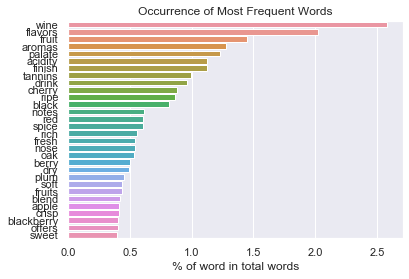

In [9]:
# Detokenizer combines tokenized elements
detokenizer = TreebankWordDetokenizer()

def wrangl_desc(desc):
    desc = word_tokenize(desc.lower())
    desc = [token for token in desc if token not in stop_words and token.isalpha()]
    return detokenizer.detokenize(desc)

df["wrangl_desc"] = df["description"].apply(wrangl_desc)
word_occurrence = df["wrangl_desc"].str.split(expand=True).stack().value_counts()
total_words = sum(word_occurrence)

# plot most common words 
top_words = word_occurrence[:30]/total_words
ax = sns.barplot(x = top_words.values * 100, y = top_words.index)
ax.set_title("Occurrence of Most Frequent Words")
ax.set_xlabel('% of word in total words')
plt.show()
#plt.savefig('Most_common_words')

The description of a wine is based on the reviewer's ability to grasp the wine's nuances and poignantly communicate those findings. We can see that there are some references to other tastes like horseradish and herbs. There are also descriptions of flavors like acidity and spiciness.  

This leads to the central question of this post: 

**Is it possible to give meaningful recommendations based on the description of a wine?**



To recommend a wine for a customer is a tricky business.  You should know how much a buyer is willing to spend on a purchase. What provinces and varieties a person prefers and how important the wine rating is for the customer.  Those points aside, the domain knowledge of sommeliers and wine salespeople is invaluable to classify wines and recommend based on experience.   

So, for this data science post, I want to investigate if the description of wines in this dataset, combined with provinces and varieties, holds enough information to base recommendations solely on these.



## Data Wrangling

### Checking for duplicates and NaN's
Overall there are 129971 different wines in the dataset with 13 columns.  

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 14 columns):
country                  129908 non-null object
description              129971 non-null object
designation              92506 non-null object
points                   129971 non-null int64
price                    120975 non-null float64
province                 129908 non-null object
region_1                 108724 non-null object
region_2                 50511 non-null object
taster_name              103727 non-null object
taster_twitter_handle    98758 non-null object
title                    129971 non-null object
variety                  129970 non-null object
winery                   129971 non-null object
wrangl_desc              129971 non-null object
dtypes: float64(1), int64(1), object(12)
memory usage: 13.9+ MB


In [11]:
# lets take a look at the NaN provinces
print(df[df['province'].isnull()].shape)
df[df['province'].isnull()]

(63, 14)


,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,wrangl_desc
913,NaN,"Amber in color, this wine has aromas of peach jam and orange blossom. Flavors are a mélange of m...",Asureti Valley,87,30.0,NaN,NaN,NaN,Mike DeSimone,@worldwineguys,Gotsa Family Wines 2014 Asureti Valley Chinuri,Chinuri,Gotsa Family Wines,amber color wine aromas peach jam orange blossom flavors mélange mellow fruit savory notes parti...
3131,NaN,"Soft, fruity and juicy, this is a pleasant, simple wine that is a blend from different European ...",Partager,83,NaN,NaN,NaN,NaN,Roger Voss,@vossroger,Barton & Guestier NV Partager Red,Red Blend,Barton & Guestier,soft fruity juicy pleasant simple wine blend different european countries balanced drinkable par...
4243,NaN,"Violet-red in color, this semisweet wine has a nose of blackberry and vanilla. It is soft on ent...",Red Naturally Semi-Sweet,88,18.0,NaN,NaN,NaN,Mike DeSimone,@worldwineguys,Kakhetia Traditional Winemaking 2012 Red Naturally Semi-Sweet Ojaleshi,Ojaleshi,Kakhetia Traditional Winemaking,color semisweet wine nose blackberry vanilla soft entry flavors black cherry blueberry creme brû...
9509,NaN,"This mouthwatering blend starts with a nose of fresh mint, pineapple and mango, followed by flav...",Theopetra Malagouzia-Assyrtiko,92,28.0,NaN,NaN,NaN,Susan Kostrzewa,@suskostrzewa,Tsililis 2015 Theopetra Malagouzia-Assyrtiko White,White Blend,Tsililis,mouthwatering blend starts nose fresh mint pineapple mango followed flavors orange peel peach le...
9750,NaN,This orange-style wine has a cloudy yellow-gold appearance because it spent 30 days on the skins...,Orange Nikolaevo Vineyard,89,28.0,NaN,NaN,NaN,Jeff Jenssen,@worldwineguys,Ross-idi 2015 Orange Nikolaevo Vineyard Chardonnay,Chardonnay,Ross-idi,wine cloudy appearance spent days skins days lees aromas flavors aged apple cider tart apple pie...
11150,NaN,"A blend of 85% Melnik, 10% Grenache Noir and 5% Petit Verdot, this wine has aromas of saddle lea...",NaN,89,20.0,NaN,NaN,NaN,Jeff Jenssen,@worldwineguys,Orbelus 2013 Melnik,Melnik,Orbelus,blend melnik grenache noir petit verdot wine aromas saddle leather cassis dark chocolate mouth f...
11348,NaN,"Light and fruity, this is a wine that has some sweetness, a gentle series of white fruits, acidi...",Partager,82,NaN,NaN,NaN,NaN,Roger Voss,@vossroger,Barton & Guestier NV Partager White,White Blend,Barton & Guestier,light fruity wine sweetness gentle series white fruits acidity lemon zest end screwcap
14030,NaN,"This Furmint, grown in marl soils, has aromas of brioche, apple tart and caramelized pear and fl...",Márga,88,25.0,NaN,NaN,NaN,Jeff Jenssen,@worldwineguys,St. Donat 2013 Márga White,White Blend,St. Donat,furmint grown marl soils aromas brioche apple tart caramelized pear flavors juice green apple li...
16000,NaN,"Jumpy, jammy aromas of foxy black fruits are slightly volatile. This has a narrow mouthfeel that...",Valle de los Manantiales Vineyard,86,40.0,NaN,NaN,NaN,Michael Schachner,@wineschach,Familia Deicas 2015 Valle de los Manantiales Vineyard Tannat,Tannat,Familia Deicas,jumpy jammy aromas foxy black fruits slightly volatile narrow mouthfeel high acidity blackened b...
16749,NaN,"Winemaker: Bartho Eksteen. This wooded Sauvy shows incredible restraint, harmony and balance. It...",Cape Winemakers Guild Vloekskoot Wooded,91,NaN,NaN,NaN,NaN,Lauren Buzzeo,@laurbuzz,Bartho Eksteen 2016 Cape Winemakers Guild Vloekskoot Wooded Sauvignon Blanc,Sauvignon Blanc,Bartho Eksteen,winemaker bartho eksteen wooded sauvy shows incredible restraint harmony balance opens attractiv...


There are 63 NaNs in the province column of the dataset.

In [12]:
# How many duplicated descriptions are in the data set?
df.duplicated('title').sum()

11131

In [13]:
# Find duplicate articles
df[df.duplicated(['title'])].sort_values(by = 'title')

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,wrangl_desc
93375,Spain,"Dusty notes of citrus fruits are mild but friendly. This Cava is zesty, fresh and simple as a wh...",Brut,87,16.0,Catalonia,Cava,NaN,Michael Schachner,@wineschach,1+1=3 NV Brut Sparkling (Cava),Sparkling Blend,1+1=3,dusty notes citrus fruits mild friendly cava zesty fresh simple whole lime clover grassy flavors...
56109,Spain,"Clean, fresh apple aromas and a minerally, citric palate are on point for brut nature. A lightly...",Cygnus Brut Nature Reserva Made With Organic Grapes,89,20.0,Catalonia,Cava,NaN,Michael Schachner,@wineschach,1+1=3 NV Cygnus Brut Nature Reserva Made With Organic Grapes Sparkling (Cava),Sparkling Blend,1+1=3,clean fresh apple aromas minerally citric palate point brut nature lightly salty set persimmon a...
100235,US,"Merlot, Cabernet and Syrah form the core of this wildly successful red blend from Ste. Michelle ...",Hot To Trot,86,10.0,Washington,Columbia Valley (WA),Columbia Valley,Paul Gregutt,@paulgwine,14 Hands 2011 Hot To Trot Red (Columbia Valley (WA)),Red Blend,14 Hands,merlot cabernet syrah form core wildly successful red blend ste michelle wine estates soft juicy...
68750,US,"In just a few years 14 Hands Riesling production has jumped from around 15,000 to more than 700,...",NaN,88,10.0,Washington,Washington,Washington Other,Paul Gregutt,@paulgwine,14 Hands 2013 Riesling (Washington),Riesling,14 Hands,years hands riesling production jumped around cases clearly brand something consumers love fairl...
57235,US,Dried herb and wood spice aromas are followed by sappy black fruit flavors backed by a light squ...,The Reserve,90,30.0,Washington,Horse Heaven Hills,Columbia Valley,Sean P. Sullivan,@wawinereport,14 Hands 2013 The Reserve Cabernet Sauvignon (Horse Heaven Hills),Cabernet Sauvignon,14 Hands,dried herb wood spice aromas followed sappy black fruit flavors backed light squeeze tannins mis...
26499,US,"Aromas are light, with notes of matchstick, herb and cherry. The cherry and plum flavors are swe...",Limited Release Kentucky Derby,87,12.0,Washington,Columbia Valley (WA),Columbia Valley,Sean P. Sullivan,@wawinereport,14 Hands 2014 Limited Release Kentucky Derby Red (Columbia Valley (WA)),Red Blend,14 Hands,aromas light notes matchstick herb cherry cherry plum flavors sweet generous providing appeal
116037,US,"The aromas of barrel spice, toast, herb and plum are reticent on first pour. On the palate, swee...",NaN,88,12.0,Washington,Columbia Valley (WA),Columbia Valley,Sean P. Sullivan,@wawinereport,14 Hands 2015 Cabernet Sauvignon (Columbia Valley (WA)),Cabernet Sauvignon,14 Hands,aromas barrel spice toast herb plum reticent first pour palate sweet fruit flavors supported lig...
108391,US,"Light aromas of lemon, apple, pineapple, toast and spice lead to just off-dry flavors. It drinks...",Brut Méthode Champenoise,87,15.0,Washington,Columbia Valley (WA),Columbia Valley,Sean P. Sullivan,@wawinereport,14 Hands NV Brut Méthode Champenoise Sparkling (Columbia Valley (WA)),Sparkling Blend,14 Hands,light aromas lemon apple pineapple toast spice lead flavors drinks little sweet brut still deliv...
73229,US,"This is the inaugural release from this Oregon-based winery, with the fruit coming from Loess an...",Proprietary,92,75.0,Oregon,Walla Walla Valley (OR),Oregon Other,Sean P. Sullivan,@wawinereport,18401 Cellars 2013 Proprietary Red (Walla Walla Valley (OR)),Bordeaux-style Red Blend,18401 Cellars,inaugural release winery fruit coming loess seven hills vineyards blend cabernet sauvignon merlo...
92133,Portugal,"With aromas of superripe fruit, this wood aged wine has a rich, toasty and lightly oxidized char...",Vinhas Velhas Branco,90,NaN,Douro,NaN,NaN,Roger Voss,@vossroger,1912 Winemakers 2011 Vinhas Velhas Branco White (Douro),Portuguese White,1912 Winemakers,aromas superripe fruit wood aged wine rich toasty lightly oxidized character case adds complexit

There are 11131 duplicated descriptions in the the dataset. Let's remove those and the duplicated descriptions and wines.

In [14]:
df.drop_duplicates('title', inplace=True)
df.drop_duplicates('description', inplace=True)
df.dropna(subset=['province', 'variety'], inplace=True)

In [15]:
# generating a long describtion: combining province, variety, and describtion of each wine
df['descr_long'] = df['province'] + ' ' + df['variety'] + ' ' + df['description']

#### Extracting the vintage of a wine from its name to filter the dataset to a specific year

In [16]:
years = df.title.str.extractall('(\d+)')
years.columns = ['year']
years.year = pd.to_numeric(years.year)
# filter vintage
years = years.query('year == 2016')

In [17]:
# check if there are duplicated index values
print(len(years))
print(years.index.get_level_values(level=0).nunique())

3296
3296


In [18]:
years.index = years.index.droplevel(level=1)

In [19]:
df = pd.concat([df, years], axis=1).dropna(subset=["year"])

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3296 entries, 77 to 129907
Data columns (total 16 columns):
country                  3296 non-null object
description              3296 non-null object
designation              2291 non-null object
points                   3296 non-null int64
price                    3165 non-null float64
province                 3296 non-null object
region_1                 2453 non-null object
region_2                 862 non-null object
taster_name              3266 non-null object
taster_twitter_handle    3113 non-null object
title                    3296 non-null object
variety                  3296 non-null object
winery                   3296 non-null object
wrangl_desc              3296 non-null object
descr_long               3296 non-null object
year                     3296 non-null float64
dtypes: float64(2), int64(1), object(13)
memory usage: 437.8+ KB


#### Generating an ID for each wine

In [21]:
wine_id = list([x for x in range(0,len(df))])
df['wine_id'] = wine_id

### Looking at the Occurances of frequent words in the descriptions

In [22]:
# setting stopwords for now and later use
stop_words = set(stopwords.words("english"))

In [23]:
# adding not relevant words to the stop_words set
irrev = {'wine', 'flavors', 'palate', 'drink', 'aromas', 'nose'}
stop_words.update(irrev)

In [24]:
# Function to get a wine description:
def print_wine(wine_id):
    try:
        wine = df[df['wine_id']==wine_id]
        title = wine.iloc[0,10]
        prov = wine.iloc[0,5]
        print("================================================================================================")
        print("Wine: {}".format(title))
        print("Province: {}".format(prov))
        print("Variety: {}".format(wine.iloc[0,11]))
        print("Points: {}".format(wine.iloc[0,3]))
        print("Taster: {}".format(wine.iloc[0,8]))
        print("Description: {}".format(wine.iloc[0,1]))
        print("================================================================================================")
    except:
        print("Please give a valid wine id (integer 0 to {})". format(len(df)))

In [25]:
print_wine(1743)

Wine: La Belle Collection 2016 La Belle Colette Rosé (Côtes de Provence)
Province: Provence
Variety: Rosé
Points: 84
Taster: Roger Voss
Description: A light and fruity wine, this is attractively crisp and with a caramel edge. The wine is bright with touches of orange and lively final acidity. Drink now.


### Transforming the wine descriptions with tf-idf

In [26]:
docs = df.set_index('wine_id').description.astype('U')

In [27]:
r = Rake()
def tokenize(text):
    # normalize case and remove punctuation
    text = re.sub(r"[^a-zA-Z]", " ", text.lower())   
    r.extract_keywords_from_text(text)
    tokens = list(r.get_word_degrees().keys())
    tokens = [token for token in tokens if token not in stop_words]
    #stemmed = [PorterStemmer().stem(w) for w in tokens]
    lemmed = [WordNetLemmatizer().lemmatize(w) for w in tokens]
    tagged = nltk.pos_tag(lemmed)
    clean_tokens = [token[0] for token in tagged if token[1][0] in ['N', 'J']]
    return clean_tokens

In [28]:
# Fit the docs to the Vectorizer
tf = TfidfVectorizer(tokenizer=tokenize, analyzer='word')
   
X_docs = tf.fit_transform(docs)
labels = list(tf.get_feature_names())

print(X_docs.toarray().shape)

(3296, 3802)


### Creating a matrix with the cosine similarity of the tf-idf values

In [29]:
# get a matrix with the tfidf values
corpus_matrix = X_docs.toarray()

# Take the dot product for the cosine similarity
dot_prod_corpus = corpus_matrix.dot(np.transpose(corpus_matrix))

# Create Dataframe with keywords:
key_words = pd.DataFrame(data=corpus_matrix, columns = labels).transpose()

### Define a function to find top n similar wines for a given wine id

In [30]:
# Function to get a wine description:
def print_wine(wine_id):
    '''
    INPUT
    wine_id - a wine id
    '''
    try:
        wine = df[df['wine_id']==wine_id]
        title = wine.iloc[0,10]
        prov = wine.iloc[0,5]
        print("================================================================================================")
        print("Wine: {}".format(title))
        print("Province: {}".format(prov))
        print("Variety: {}".format(wine.iloc[0,11]))
        print("Points: {}".format(wine.iloc[0,3]))
        print("Taster: {}".format(wine.iloc[0,8]))
        print("Description: {}".format(wine.iloc[0,1]))
        print("================================================================================================")
    except:
        print("Please give a valid wine id (integer 0 to {})". format(len(df)))

In [31]:
def get_wine_names(wine_ids):
    '''
    INPUT
    wine_id - a wine id
    OUTPUT
    wines - a list of wines associated with the wine_ids
    
    '''
    if type(wine_ids)==int:
        wine_ids = [wine_ids]
    wine_lst = [df[df.wine_id==wine]['title'].to_string(index=False,header=False) for wine in wine_ids]    
   
    return wine_lst

In [32]:
def find_similar_wines(wine_id, n=5):
    '''
    INPUT
    wine_id - a wine id
    n - number of similar wines to return
    OUTPUT
    df_sim - a dataframe of the most similar wines by id, name and similarity
    '''
    # find the most similar wine indices 
    key_words_sims = []
    
    similar_idxs = np.argsort(dot_prod_corpus[wine_id])[::-1][1:n+1]
    sims = np.sort(dot_prod_corpus[wine_id])[::-1][1:n+1]
    for idx in similar_idxs:
        wine_keys = key_words[key_words[idx] > 0][idx]
        wine_keys = list(wine_keys.index)[::1]
        key_words_sims.append(wine_keys)

    # pull the movie titles based on the indices
    similar_wines = get_wine_names(similar_idxs)
    
    # dataframe with similarities:
    d = {'wine_id': similar_idxs, 
         'wine': similar_wines,
        'similarity': sims, 
        'key_words': key_words_sims}
    df_sims = pd.DataFrame(d)
 
    return df_sims

df_sims = find_similar_wines(24)
print(get_wine_names(24))
df_sims.head()

[' Zahel 2016 White (Wiener Gemischter Satz)']


,wine_id,wine,similarity,key_words
0,2199,Ebner-Ebenauer 2016 Grüner Veltliner (Niederösterreich),0.309666,"[ample, apple, body, bright, conference, dry, finish, freshness, green, lemon, light, pear, shy,..."
1,2937,Domaine Martin 2016 Les Trois Versants Sur Lie (Muscadet Sèvre et Maine),0.291337,"[acidity, apple, aromatic, citrus, crisp, delicious, full, ripe, zingy]"
2,2807,Stadlmann 2016 Badener Berg Riesling (Niederösterreich),0.263501,"[aromatic, body, brings, citrus, dry, element, force, fresh, full, grapefruit, juiciness, life, ..."
3,2341,Müller-Grossmann 2016 Rosé vom Zweigelt (Niederösterreich),0.251625,"[aroma, citrus, clean, dry, dulls, finish, fresh, light, load, note, redcurrant, reduction, slight]"
4,427,Domaine G. Metz 2016 Melody Riesling (Alsace),0.231798,"[add, apple, body, citrus, delicious, dry, finish, freshness, golden, hint, lemon, lemony, light..."


In [33]:
print_wine(24)
for i in df_sims.wine_id:
    print(i)
    print_wine(i)

Wine: Zahel 2016 White (Wiener Gemischter Satz)
Province: Wiener Gemischter Satz
Variety: White Blend
Points: 90
Taster: Anne Krebiehl MW
Description: Slight reduction still obstructs this wine's nose. The palate, however, is both zingy and rich—spiked with citrus and rounded with ripe, mellow apple fruit. There is verve and life at its core and tone to its medium body. The dry finish is appetizing.
2199
Wine: Ebner-Ebenauer 2016 Grüner Veltliner (Niederösterreich)
Province: Niederösterreich
Variety: Grüner Veltliner
Points: 89
Taster: Anne Krebiehl MW
Description: The nose is rather shy, while the palate brings freshly cut green apple and Conference pear. This is precisely but finely drawn with ample lemon freshness and bright verve. The body is light and dry. Bright, lively lemon on the finish sets the tone.
2937
Wine: Domaine Martin 2016 Les Trois Versants Sur Lie  (Muscadet Sèvre et Maine)
Province: Loire Valley
Variety: Melon
Points: 88
Taster: Roger Voss
Description: Lightly arom

### Create a function for content based recommendations

In [34]:
# Lets asume there are 100 consumers who bought each 5 wines
customer_dict = {}
for cust in range(1,101):
    customer_dict[cust]= list(np.random.randint(len(df), size=5))
customer_dict[2]

[1971, 1885, 1433, 2827, 1119]

In [35]:
def make_content_recs(n=5):
    '''
    INPUT
    n - Number of recommendations by user (default = 10)
    OUTPUT
    recs - a dictionary with keys of the user and values of the recommendations
    '''
    # Create dictionary to return with customers and recommendations
    recs = defaultdict(list)
    
    # How many customers for progress bar
    n_users = len(customer_dict)  
    # Create the progressbar
    cnter = 0
    bar = progressbar.ProgressBar(maxval=n_users+1, 
                                  widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    
    # For each customer
    for cust in customer_dict:
        # Update the progress bar
        cnter+=1 
        bar.update(cnter)
        
        # Wines allready consumed:
        cust_wines = customer_dict[cust]
        
        # find the simmilar wines for each wine_id and concat the data for all articles of the user:
        df_recs = pd.DataFrame()
        for wine_id in customer_dict[cust]:
            df_sim = find_similar_wines(wine_id)
            df_recs = pd.concat([df_recs,df_sim])
            
        #Sorting all wines according the similarity accross all suggestions
        df_recs = df_recs.sort_values('similarity', ascending=False).drop_duplicates('wine_id')
        
        # getting just the ids and filter allready bought wines:
        temp_recs = [wine for wine in df_recs.wine_id if wine not in cust_wines]
        
        # creating the dictionary with just the top n recommendations
        recs[cust]=temp_recs[:n]
        
    bar.finish()
    return recs

In [36]:
recommendations = make_content_recs()

[========================================================================] 100%


In [37]:
# Bought wines from customer 1:
for i in customer_dict[1]:
    print(i)
    print_wine(i)

3268
Wine: Andrero 2016 Grillo (Terre Siciliane)
Province: Sicily & Sardinia
Variety: Grillo
Points: 85
Taster: Kerin O’Keefe
Description: Exotic fruit and herbaceous aromas lift out of the glass. On the bright, simple palate, zesty acidity underscores juicy pineapple and grapefruit notes.
1019
Wine: Manuel Carvalho Martins 2016 Golpe Branco White (Douro)
Province: Douro
Variety: Portuguese White
Points: 90
Taster: Roger Voss
Description: The wine is richly textured and full of ripe fruits. Crisp acidity contrasts with the warm yellow-fruit and ripe red-apple flavors. It is already a refreshing crisp wine with a fine dense texture. Drink from late 2017.
1854
Wine: Laurence Féraud 2016 Pink Pégau Rosé (Vin de France)
Province: France Other
Variety: Rosé
Points: 89
Taster: Joe Czerwinski
Description: This is made from 80% Cinsault, 10% Grenache and 10% Carignan. It has a deep pink hue and smells more like a red wine than many rosés, with hints of smoked meat, bold notes of garrigue and j

In [38]:
# Recommendations for customer 1
for i in recommendations[1]:
    print(i)
    print_wine(i)

3124
Wine: Antica Hirpinia 2016  Greco di Tufo
Province: Southern Italy
Variety: Greco
Points: 85
Taster: Kerin O’Keefe
Description: This simple white offers exotic fruit aromas while the bright palate shows banana and pineapple notes. Zesty acidity gives it a refreshing finish.
322
Wine: Bernard et Christophe Richel 2016 Apremont Jacquère (Vin de Savoie)
Province: France Other
Variety: Jacquère
Points: 85
Taster: Roger Voss
Description: This wine is crisp with refreshing acidity and fine lemon and grapefruit flavors. It's light and poised while still packing tangy fruit. Drink now.
3223
Wine: Colosi 2016 Grillo (Terre Siciliane)
Province: Sicily & Sardinia
Variety: Grillo
Points: 86
Taster: Kerin O’Keefe
Description: Aromas of white wild flower and exotic fruit spring from the glass. The lively fruity palate doles out honeydew melon and juicy grapefruit alongside bright acidity.
60
Wine: Vinadeis 2016 Le Val Merlot (Vin de France)
Province: France Other
Variety: Merlot
Points: 85
Tast